## Key Components
1. **State Management**: Using TypedDict to define and manage the state of each customer interaction.
2. **Query Categorization**: Classifying customer queries into Technical, Billing, or General categories.
3. **Sentiment Analysis**: Determining the emotional tone of customer queries.
4. **Response Generation**: Creating appropriate responses based on the query category and sentiment.
5. **Escalation Mechanism**: Automatically escalating queries with negative sentiment to human agents.
6. **Workflow Graph**: Utilizing LangGraph to create a flexible and extensible workflow.

## Method Details
1. **Initialization**: Set up the environment and import necessary libraries.
2. **State Definition**: Create a structure to hold query information, category, sentiment, and response.
3. **Node Functions**: Implement separate functions for categorization, sentiment analysis, and response generation.
4. **Graph Construction**: Use StateGraph to define the workflow, adding nodes and edges to represent the support process.
5. **Conditional Routing**: Implement logic to route queries based on their category and sentiment.
6. **Workflow Compilation**: Compile the graph into an executable application.
7. **Execution**: Process customer queries through the workflow and retrieve results.

In [ ]:
!pip install langchain langchain_core langchain_groq langchain_community langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: langchain_core
    Found existing installation: langchain-core 0.3.25
    Uninstalling langchain-core-0.3.25:
      Successfully uninstalled langchain-core-0.3.25
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.12
    Uninstalling langchain-0.3.12:
      Successfully uninstalled langchain-0.3.12


In [ ]:
from typing import TypedDict, Dict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display , Image

Define State Structure

In [ ]:
class State(TypedDict):
  query: str
  category: str
  sentiment: str
  response: str

In [ ]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    temperature=0,
    groq_api_key = "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",
    model_name = "llama-3.3-70b-versatile"
)
result = llm.invoke("What is langchain")
result.content

'LangChain is an open-source framework designed to help developers build applications that utilize large language models (LLMs) more efficiently. It was created to simplify the process of integrating LLMs into various projects, making it easier for developers to leverage the capabilities of these powerful models.\n\nLangChain provides a set of tools and libraries that enable developers to:\n\n1. **Interact with LLMs**: LangChain offers a unified interface to interact with different LLMs, such as LLaMA, PaLM, and others, allowing developers to write code that works across multiple models.\n2. **Manage memory and caching**: LangChain includes features to manage memory and caching, which helps reduce the computational resources required to run LLMs and improves overall performance.\n3. **Implement indexing and retrieval**: LangChain provides tools for indexing and retrieving information from LLMs, making it easier to build applications that require searching, filtering, or ranking of resu

Define Node Function

In [ ]:
def categorize(state: State) -> State:
  "Technical, Billing, General"
  prompt = ChatPromptTemplate.from_template(
      "Categorize the following customer query into one of these categories: "
      "Technical, Billing, General. Query: {query}"
  )
  chain = prompt | llm
  category = chain.invoke({"query": state["query"]}).content
  return {"category": category}

def analyze_sentiment(state: State) -> State:
  prompt = ChatPromptTemplate.from_template(
      "Analyze the sentiment of the following customer query"
      "Response with either 'Position', 'Neutral' , or 'Negative'. Query: {query}"
  )
  chain = prompt | llm
  sentiment = chain.invoke({"query": state["query"]}).content
  return {"sentiment": sentiment}

def handle_technical(state: State)->State:
  prompt = ChatPromptTemplate.from_template(
      "Provide a technical support response to the following query : {query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query": state["query"]}).content
  return {"response": response}

def handle_billing(state: State)->State:
  prompt = ChatPromptTemplate.from_template(
      "Provide a billing support response to the following query : {query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query": state["query"]}).content
  return {"response": response}

def handle_general(state: State)->State:
  prompt = ChatPromptTemplate.from_template(
      "Provide a general support response to the following query : {query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query": state["query"]}).content
  return {"response": response}

def escalate(state: State)->State:
  return {"response": "This query has been escalate to a human agent due to its negative sentiment"}

def route_query(state: State)->State:
  if state["sentiment"] == "Negative":
    return "escalate"
  elif state["category"] == "Technical":
    return "handle_technical"
  elif state["category"] == "Billing":
    return "handle_billing"
  else:
    return "handle_general"

Create and configure the graph

In [ ]:
workflow = StateGraph(State)

workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query,{
        "handle_technical" : "handle_technical",
        "handle_billing" :  "handle_billing",
        "handle_general" : "handle_general",
        "escalate": "escalate"
    }
)

workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

workflow.set_entry_point("categorize")

app  = workflow.compile()

Visulize the graph

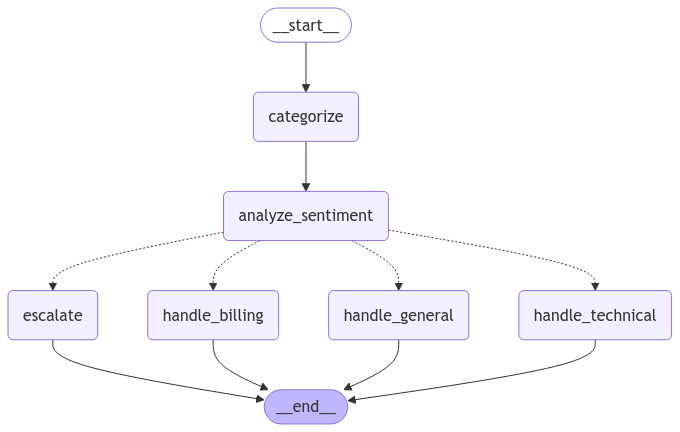

In [ ]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

Run customer support function

In [ ]:
def run_customer_support(query: str)->Dict[str, str]:
  results = app.invoke({"query": query})
  return {
      "category":results['category'],
      "sentiment":results['sentiment'],
      "response": results['response']
  }

In [ ]:
query = "My internet connection is gone it's not working, Can you help me?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

Query: My internet connection is gone it's not working, Can you help me?
Category: The customer query can be categorized as: Technical.

The query is related to a technical issue with the customer's internet connection, and they are seeking assistance to resolve the problem.
Sentiment: Neutral. 

The customer is reporting an issue with their internet connection and is seeking help, but they are not expressing any emotions such as frustration, anger, or dissatisfaction that would indicate a negative sentiment. The tone is more matter-of-fact and inquiring, which is why it's classified as neutral.
Response: I'm so sorry to hear that your internet connection is not working. I'd be happy to help you troubleshoot the issue. 

To get started, can you please try a few basic steps:

1. **Restart your router**: Sometimes, a simple reboot can resolve the issue. Unplug the power cord from your router, wait for 30 seconds, and then plug it back in.
2. **Check your cables**: Ensure that all cables 

In [ ]:
query = "where can i find my receipt"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

Query: where can i find my receipt
Category: The customer query "where can I find my receipt" would be categorized as: Billing.
Sentiment: Neutral. 

The customer is simply asking for information about the location of their receipt, without expressing any emotion or sentiment, either positive or negative.
Response: I'd be happy to help you locate your receipt. There are a few possible places you can check, depending on how you made your purchase. Here are some suggestions:

1. **Email**: If you made an online purchase, check your email inbox for a confirmation email that may include your receipt.
2. **Order History**: If you have an account with the retailer, log in and check your order history. Many retailers store receipts and order details in this section.
3. **Store Website**: Visit the retailer's website and look for a "My Account" or "Order Status" section, where you may be able to access your receipt.
4. **Mobile App**: If you made a purchase through a mobile app, check the app'

In [ ]:
!pip install gradio

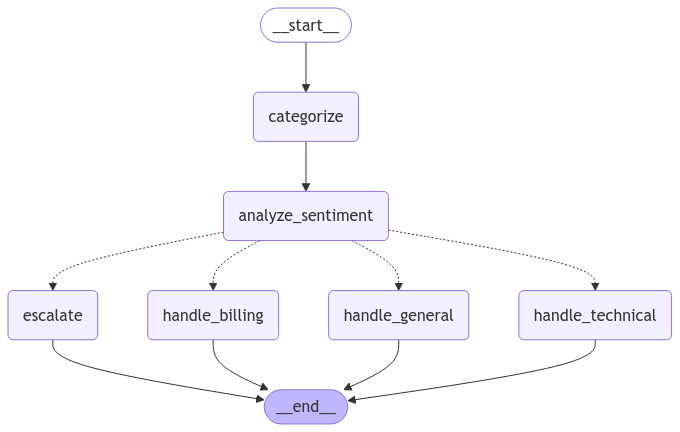

themes/theme_schema@0.0.1.json:   0%|          | 0.00/12.6k [00:00<?, ?B/s]

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c1cfca819cd4422f5f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
from typing import TypedDict, Dict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

class State(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str

from langchain_groq import ChatGroq

llm = ChatGroq(
    temperature=0,
    groq_api_key="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",
    model_name="llama-3.3-70b-versatile"
)


def categorize(state: State) -> State:
    """Categorize the query."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories: "
        "Technical, Billing, General. Query: {query}"
    )
    chain = prompt | llm
    category = chain.invoke({"query": state["query"]}).content
    return {"category": category}

def analyze_sentiment(state: State) -> State:
    """Analyze sentiment of the query."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query "
        "Response with either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
    )
    chain = prompt | llm
    sentiment = chain.invoke({"query": state["query"]}).content
    return {"sentiment": sentiment}

def handle_technical(state: State) -> State:
    """Handle technical queries."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a technical support response to the following query: {query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_billing(state: State) -> State:
    """Handle billing queries."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a billing support response to the following query: {query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_general(state: State) -> State:
    """Handle general queries."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query: {query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def escalate(state: State) -> State:
    """Escalate negative sentiment queries."""
    return {"response": "This query has been escalated to a human agent due to its negative sentiment."}

def route_query(state: State) -> State:
    """Route query based on category and sentiment."""
    if state["sentiment"] == "Negative":
        return "escalate"
    elif state["category"] == "Technical":
        return "handle_technical"
    elif state["category"] == "Billing":
        return "handle_billing"
    else:
        return "handle_general"

workflow = StateGraph(State)

workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query, {
        "handle_technical": "handle_technical",
        "handle_billing": "handle_billing",
        "handle_general": "handle_general",
        "escalate": "escalate"
    }
)

workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

workflow.set_entry_point("categorize")

app = workflow.compile()

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

import gradio as gr

# Define the function that integrates the workflow.
def run_customer_support(query: str) -> Dict[str, str]:
    results = app.invoke({"query": query})
    return {
        "Category": results['category'],
        "Sentiment": results['sentiment'],
        "Response": results['response']
    }

# Create the Gradio interface
def gradio_interface(query: str):
    result = run_customer_support(query)
    return (
        f"**Category:** {result['Category']}\n\n"
        f"**Sentiment:** {result['Sentiment']}\n\n"
        f"**Response:** {result['Response']}"
    )

# Build the Gradio app
gui = gr.Interface(
    fn=gradio_interface,
    theme='Yntec/HaleyCH_Theme_Orange_Green',
    inputs=gr.Textbox(lines=2, placeholder="Enter your query here..."),
    outputs=gr.Markdown(),
    title="Customer Support Assistant",
    description="Provide a query and receive a categorized response. The system analyzes sentiment and routes to the appropriate support channel.",
)

# Launch the app
if __name__ == "__main__":
    gui.launch()
